# Objective 
    Building a siamese network that classifies two images based on the
    similarity value calculated using the pairwise absolute or euclidean
    distance and then predicting the label using K-way-10 shot predicting 
    algorithm i.e we use 10 images for each class as  representatives and
    compare them with the current image. 

    References:https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a


### Necessary Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.utils.data
from torch.autograd import Variable
from torchsummary import summary
from torchvision.utils import save_image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              transforms.Resize((105,105))
                              ])
                              '''

transform = transforms.ToTensor()

### Data Preprocessing 

### Load the training set

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
type(train_data)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torchvision.datasets.mnist.MNIST

### Load the test set
There's a companion set of MNIST data containing 10,000 records accessible by setting train=False. As before, torchvision will only download this once, and in the future will look for the local copy.

In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
model_data=train_data+test_data
total_count=len(model_data)
model_data

### Split 70:30

In [6]:
train_count = int(0.7 * total_count) 
test_count = int(0.3 * total_count)

In [7]:
train_data, test_data = torch.utils.data.random_split(model_data, (train_count, test_count))
print(len(train_data))
print(len(test_data))
type(train_data)

49000
21000


torch.utils.data.dataset.Subset

In [8]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Calling the first record from <tt>train_data</tt> returns a two-item tuple. The first item is our 28x28 tensor representing the image. The second is a label, in this case the number "5".

In [9]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 8


### View the image
Matplotlib can interpret pixel values through a variety of <a href='https://matplotlib.org/tutorials/colors/colormaps.html'>colormaps</a>.

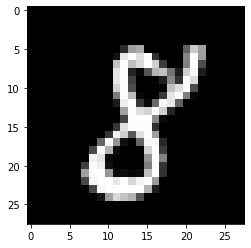

In [10]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray"); 

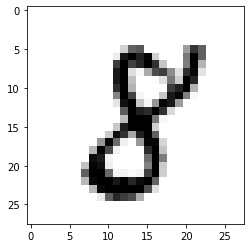

In [11]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg"); 

### Defining the Siamese Network
    In this we will define single network instead of two networks 
    sharing the same weights and being identical. we can pass the two
    images successively to emulate the function of two networks 

In [15]:
### Reference : https://datascience.stackexchange.com/questions/40906/determining-size-of-fc-layer-after-conv-layer-in-pytorch
## Reference :https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a

class SiameseNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0)
        self.batch_norm1=nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, padding=0)
        self.batch_norm2=nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=2, padding=0)
        self.batch_norm3=nn.BatchNorm2d(256)
       
  

        self.fc1 = nn.Linear(256 *2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)

        self.fcout=nn.Linear(128,1)

        self.sigmoid=nn.Sigmoid()
    

    def forward_once(self, X):
        X = F.relu(self.batch_norm1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.batch_norm2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.batch_norm3(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(X.size(0), -1)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)

        return X

        #return F.log_softmax(X, dim=1)
    
    def forward(self,in1,in2):
        #https://stackoverflow.com/questions/57237381/runtimeerror-expected-4-dimensional-input-for-4-dimensional-weight-32-3-3-but
        out1=self.forward_once(in1)  ### because pytorch expects in batches, to support singleton batch
        #out1 = self.sigmoid(out1)
        out2=self.forward_once(in2)
        #out2 =  self.sigmoid(out2)
        #out3=self.forward_once(in3)
        #out3 =  self.sigmoid(out3)
        #out=torch.abs(out1 - out2)
        #x = torch.abs(out1 - out2)
        #return x

        return out1,out2       #,out3

        #return self.fcout(out)

    def evaluate1(self,x,y):

      out=torch.abs(x - y)
      #out=self.fcout(out)

      return out
    
    def evaluate2(self,x,y):

      out=torch.abs(x - y)
      out=self.fcout(out)

      return out

    def evaluate(self,x):

      out=self.forward_once(x)
      return out


        
        

### Count the model parameters
This optional step shows that the number of trainable parameters in our model matches the equation above.

In [14]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

### Defining the contrastive loss

In [16]:

#######################  Reference #######################################
### https://medium.com/hackernoon/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

### Defining custom function to make pairs

In [17]:
###################################   Reference ##############################
## https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/



def make_pairs(images, labels):
	
	pairImages = []
	pairLabels = []
	
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
	
	for idxA in range(len(images)):
	
		currentImage = images[idxA]
		label = labels[idxA]
		
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]
		
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])                            ### positive image means similar so appending 1
		
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	
	return (np.array(pairImages), np.array(pairLabels))

### Loading and preparing the data set 
    https://stackoverflow.com/questions/54897646/pytorch-datasets-converting-entire-dataset-to-numpy
    

In [18]:
#train_dataset_array = next(iter(train_loader))[0].numpy()
#test_dataset_array = next(iter(test_loader))[0].numpy()

In [19]:
#train_labels_array=next(iter(train_loader))[1].numpy()
#test_labels_array =next(iter(test_loader))[1].numpy()

In [20]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageDataset):
        self.imageDataset = imageDataset    
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageDataset)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageDataset) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageDataset)

        #img0 = Image.open(img0_tuple[0])
        img0 = img0_tuple[0]
        #img1 = Image.open(img1_tuple[0])
        img1 = img1_tuple[0]
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")

        '''
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        '''

        if img0_tuple[1] == img1_tuple[1]:
            label=1.0
        else:
            label=0.0
        
        
        
        return img0, img1 ,torch.from_numpy(np.array([label], dtype=np.float32))  
    
    def __len__(self):
        return len(self.imageDataset)

In [21]:
from collections import OrderedDict

class EvalSet(Dataset):

    def __init__(self, imageDataset,setSize=10,numWay=10):
        self.imageDataset = imageDataset
        self.setSize = setSize
        self.numWay = numWay
    def __len__(self):
        return self.setSize
    def __getitem__(self, idx):
        # find one main image
        mainImg = random.choice(self.imageDataset)
        label = mainImg[1]
        mainImg = mainImg[0]
        

        #seen_indices=[]

        # find n numbers of distinct images, 1 in the same set as the main
        testSet = []

        for i in range(self.numWay):

            while True:
                testImgName = random.choice(self.imageDataset)
                if int(testImgName[1]) == i:
                    break

            testSet.append(testImgName[0])
        return mainImg, testSet, torch.from_numpy(np.array([label], dtype = int))



## Using Contrastive loss

In [ ]:
torch.manual_seed(101) 
modelcontrast=SiameseNetwork()
modelcontrast


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
count_parameters(modelcontrast)

   144
    16
    16
    16
  2048
    32
    32
    32
 32768
   256
   256
   256
262144
   256
 32768
   128
   128
     1
______
331297


In [ ]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.0005
criterion = nn.CosineEmbeddingLoss()                   ### it is similar to contrastive loss except that it uses cosine distance I have given margin as 4
optimizer=torch.optim.Adam(modelcontrast.parameters(),lr=0.001)

In [ ]:

torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
train_dataset=SiameseNetworkDataset(train_data)
test_dataset=SiameseNetworkDataset(test_data)

In [35]:
def inference(in1,in2):
  cityblock_dist=F.pairwise_distance(in1, in2,p=2)
  m = nn.Sigmoid()
  return m(cityblock_dist)

In [36]:
def evaluate(in1,in2):
  
  cityblock_dist=F.pairwise_distance(in1, in2,p=2)
  m = nn.Sigmoid()
  if m(cityblock_dist) >=0.5:
    return 0 # not similar
  return 1    # similar 

In [33]:
######## Preparing the support set 
from collections import OrderedDict
support_size=1000
numClasses=10 #each class contains 100 images as a support set 
k_way_dict=OrderedDict()
j=0
for i in range(0,10):
    coun=0
    k_way_dict[i]=[]
    while True:
      sample=train_data[j]
      j+=1
      if sample[1]==i:
        k_way_dict[i].append(sample[0])
        #print(j)
        coun+=1
      if coun==10:
        break
  

In [ ]:
# training and validation loss were calculated after every epoch
import time
start_time = time.time()
num_epochs=13
device='cpu'
train_losses = []
val_losses = []
cur_step = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    modelcontrast.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2,labels in train_loader:    # , label1,label2
        #labels = labels.to(device)
        output1,output2 = modelcontrast(img1, img2)
        out = modelcontrast.evaluate2(output1,output2)
        #print(out)
        #print(labels)
       # labels=labels.type(torch.LongTensor)
        loss = criterion(out,labels,Variable(torch.Tensor(out.size(0))))     ### very important to include the size(0) of predicted variable 
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    #break

    print('Epoch [{}/{}],Train Loss: {:.4f}'
        .format(epoch+1, num_epochs, avg_train_loss))
print("Finished Training")  
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

Starting epoch 1
Epoch [1/13],Train Loss: 0.0000
Starting epoch 2
Epoch [2/13],Train Loss: 0.0000
Starting epoch 3
Epoch [3/13],Train Loss: 0.0000
Starting epoch 4
Epoch [4/13],Train Loss: 0.0000
Starting epoch 5
Epoch [5/13],Train Loss: 0.0000
Starting epoch 6
Epoch [6/13],Train Loss: 0.0000
Starting epoch 7
Epoch [7/13],Train Loss: 0.0000
Starting epoch 8
Epoch [8/13],Train Loss: 0.0000
Starting epoch 9
Epoch [9/13],Train Loss: 0.0000
Starting epoch 10
Epoch [10/13],Train Loss: 0.0000
Starting epoch 11
Epoch [11/13],Train Loss: 0.0000
Starting epoch 12
Epoch [12/13],Train Loss: 0.0000
Starting epoch 13
Epoch [13/13],Train Loss: 0.0000
Finished Training

Duration: 1339 seconds


In [ ]:
train_losses

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

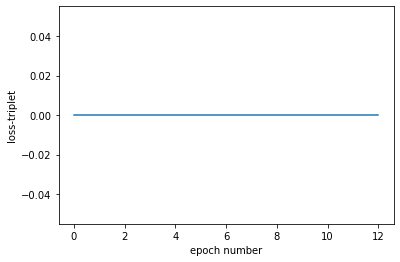

In [ ]:

plt.xlabel('epoch number')
plt.ylabel('loss-triplet')

plt.plot(np.arange(num_epochs),train_losses)

In [ ]:

with torch.no_grad():

    modelentropy.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(10000):
      sample=test_data[i]

      output1=modelcontrast.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=modelcontrast.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.615
Current Count is: 400
Accuracy on n way: 0.6075
Current Count is: 600
Accuracy on n way: 0.6
Current Count is: 800
Accuracy on n way: 0.61125
Current Count is: 1000
Accuracy on n way: 0.619
Current Count is: 1200
Accuracy on n way: 0.6175
Current Count is: 1400
Accuracy on n way: 0.6228571428571429
Current Count is: 1600
Accuracy on n way: 0.620625
Current Count is: 1800
Accuracy on n way: 0.615
Current Count is: 2000
Accuracy on n way: 0.6135
Current Count is: 2200
Accuracy on n way: 0.610909090909091
Current Count is: 2400
Accuracy on n way: 0.6133333333333333
Current Count is: 2600
Accuracy on n way: 0.6157692307692307
Current Count is: 2800
Accuracy on n way: 0.6121428571428571
Current Count is: 3000
Accuracy on n way: 0.6186666666666667
Current Count is: 3200
Accuracy on n way: 0.6171875
Current Count is: 3400
Accuracy on n way: 0.6120588235294118
Current Count is: 3600
Accuracy on n way: 0.6094444444444445
Current Count is: 3800
Accu

In [ ]:
print('Final Test Accuracy if {:.4f}'.format(correct*100/count))

Final Test Accuracy if 60.1400


## Using triplet loss

### Slight modifications to the class added additional input

In [ ]:
class SiameseTripletDataset(Dataset):
    
    def __init__(self,imageDataset):
        self.imageDataset = imageDataset    
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageDataset)
        #we need to make sure approx 50% of images are in the same class
        #should_get_same_class = random.randint(0,1) 
        #if should_get_same_class:
        while True:
            #keep looping till the same class image is found
            img1_tuple = random.choice(self.imageDataset) 
            if img0_tuple[1]==img1_tuple[1]:
                break

        while True:
            img2_tuple = random.choice(self.imageDataset)
            if img0_tuple[1]!=img2_tuple[1]:
                break

        #img0 = Image.open(img0_tuple[0])
        img0 = img0_tuple[0]
        #img1 = Image.open(img1_tuple[0])
        img1 = img1_tuple[0]
        img2 = img2_tuple[0]
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")

        '''
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        '''
        
        return img0, img1, img2 #torch.from_numpy(np.array([1],dtype=np.float32)),torch.from_numpy(np.array([0],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageDataset)

In [ ]:
train_dataset=SiameseTripletDataset(train_data)

test_dataset=SiameseTripletDataset(train_data)

In [ ]:

torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
### Reference : https://datascience.stackexchange.com/questions/40906/determining-size-of-fc-layer-after-conv-layer-in-pytorch
## Reference :https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a

class SiameseTriplet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=0)
        self.batch_norm1=nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, padding=0)
        self.batch_norm2=nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=2, padding=0)
        self.batch_norm3=nn.BatchNorm2d(256)
       
  

        self.fc1 = nn.Linear(256 *2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)

        self.fcout=nn.Linear(128,1)

        self.sigmoid=nn.Sigmoid()
    

    def forward_once(self, X):
        X = F.relu(self.batch_norm1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.batch_norm2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.batch_norm3(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(X.size(0), -1)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)

        return X

        #return F.log_softmax(X, dim=1)
    
    def forward(self,in1,in2,in3):
        #https://stackoverflow.com/questions/57237381/runtimeerror-expected-4-dimensional-input-for-4-dimensional-weight-32-3-3-but
        out1=self.forward_once(in1)  ### because pytorch expects in batches, to support singleton batch
        #out1 = self.sigmoid(out1)
        out2=self.forward_once(in2)
        #out2 =  self.sigmoid(out2)
        out3=self.forward_once(in3)
        #out3 =  self.sigmoid(out3)
        #out=torch.abs(out1 - out2)
        #x = torch.abs(out1 - out2)
        #return x

        return out1,out2,out3

        #return self.fcout(out)

    def evaluate1(self,x,y):

      out=torch.abs(x - y)
      #out=self.fcout(out)

      return out
    
    def evaluate2(self,x,y):

      out=torch.abs(x - y)
      out=self.fcout(out)

      return out

    def evaluate(self,x):

      out=self.forward_once(x)
      return out

        
 

In [ ]:
#TripletMarginLoss()
#SiameseTriplet

In [ ]:
torch.manual_seed(101) 
modelTriplet=SiameseTriplet()
modelTriplet


SiameseTriplet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
count_parameters(modelTriplet)

   144
    16
    16
    16
  2048
    32
    32
    32
 32768
   256
   256
   256
262144
   256
 32768
   128
   128
     1
______
331297


In [ ]:
#criterion=ContrastiveLoss()
criterion = nn.TripletMarginLoss()
optimizer=torch.optim.Adam(modelTriplet.parameters(),lr=0.001)

### Training using triplet loss

In [ ]:
def evaluateTriplet(in1,in2):
  
  cityblock_dist=F.pairwise_distance(in1, in2,p=2)
  m = nn.Sigmoid()
  if m(cityblock_dist) >=0.5:
    return 0 # not similar
  return 1    # similar 

In [ ]:
# training and validation loss were calculated after every epoch
import time
start_time = time.time()
num_epochs=10
device='cpu'
train_losses = []
val_losses = []
cur_step = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    modelTriplet.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2,img3 in train_loader:    # , label1,label2
        #labels = labels.to(device)
        output1,output2, output3 = modelTriplet(img1, img2,img3)


        loss = criterion(output1,output2, output3)
        
        #in1=modelTriplet.evaluate1(output1,output2)
        #out=modelTriplet.evaluate2(in1,output3)
        #print(out)
        #print(label1)
        #print(label2)
        #break


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    #break

    print('Epoch [{}/{}],Train Loss: {:.4f}'
        .format(epoch+1, num_epochs, avg_train_loss))
print("Finished Training")  
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

Starting epoch 1
Epoch [1/10],Train Loss: 0.0676
Starting epoch 2
Epoch [2/10],Train Loss: 0.0346
Starting epoch 3
Epoch [3/10],Train Loss: 0.0333
Starting epoch 4
Epoch [4/10],Train Loss: 0.0225
Starting epoch 5
Epoch [5/10],Train Loss: 0.0205
Starting epoch 6
Epoch [6/10],Train Loss: 0.0175
Starting epoch 7
Epoch [7/10],Train Loss: 0.0148
Starting epoch 8
Epoch [8/10],Train Loss: 0.0167
Starting epoch 9
Epoch [9/10],Train Loss: 0.0125
Starting epoch 10
Epoch [10/10],Train Loss: 0.0124
Finished Training

Duration: 1661 seconds


In [ ]:
train_losses

[0.06763548352114133,
 0.034585384911933574,
 0.03327278416502534,
 0.022545746358498167,
 0.020505352258258853,
 0.017489072058631382,
 0.014772353630892862,
 0.016708360656048173,
 0.012497822648123363,
 0.012430928571974415]

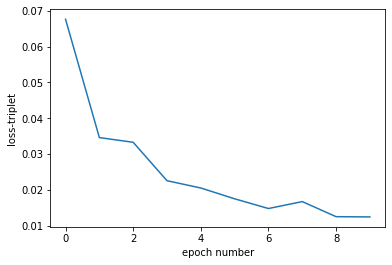

In [ ]:

plt.xlabel('epoch number')
plt.ylabel('loss-triplet')

plt.plot(np.arange(num_epochs),train_losses)

In [ ]:
######## Preparing the support set 
from collections import OrderedDict
support_size=100
numClasses=10 #each class contains 10 images as a support set 
k_way_dict=OrderedDict()
j=0
for i in range(0,10):
    coun=0
    k_way_dict[i]=[]
    while True:
      sample=train_data[j]
      j+=1
      if sample[1]==i:
        k_way_dict[i].append(sample[0])
        #print(j)
        coun+=1
      if coun==10:
        break
  

In [ ]:
len(k_way_dict[0])

10

In [ ]:

with torch.no_grad():

    modelTriplet.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(len(test_data)):
      sample=test_data[i]

      output1=modelTriplet.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=modelTriplet.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.965
Current Count is: 400
Accuracy on n way: 0.975
Current Count is: 600
Accuracy on n way: 0.9716666666666667
Current Count is: 800
Accuracy on n way: 0.96625
Current Count is: 1000
Accuracy on n way: 0.969
Current Count is: 1200
Accuracy on n way: 0.9675
Current Count is: 1400
Accuracy on n way: 0.9685714285714285
Current Count is: 1600
Accuracy on n way: 0.968125
Current Count is: 1800
Accuracy on n way: 0.9677777777777777
Current Count is: 2000
Accuracy on n way: 0.9705
Current Count is: 2200
Accuracy on n way: 0.9713636363636363
Current Count is: 2400
Accuracy on n way: 0.96875
Current Count is: 2600
Accuracy on n way: 0.9692307692307692
Current Count is: 2800
Accuracy on n way: 0.9689285714285715
Current Count is: 3000
Accuracy on n way: 0.9693333333333334
Current Count is: 3200
Accuracy on n way: 0.969375
Current Count is: 3400
Accuracy on n way: 0.9697058823529412
Current Count is: 3600
Accuracy on n way: 0.9705555555555555
Current Cou

In [ ]:
print('Final Test Accuracy if {:.4f} %'.format(correct*100/count))

Final Test Accuracy if 97.3048 %


## Using cross entropy losss

In [ ]:
torch.manual_seed(101) 
modelentropy=SiameseNetwork()
modelentropy


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
count_parameters(modelentropy)

   144
    16
    16
    16
  2048
    32
    32
    32
 32768
   256
   256
   256
262144
   256
 32768
   128
   128
     1
______
331297


In [ ]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.0005
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(modelentropy.parameters(),lr=0.001,weight_decay=0.0005)

In [ ]:
train_dataset=SiameseNetworkDataset(train_data)
test_dataset=SiameseNetworkDataset(test_data)

In [ ]:

torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# training and validation loss were calculated after every epoch
import time
start_time = time.time()
num_epochs=10
device='cpu'
train_losses = []
val_losses = []
cur_step = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    modelentropy.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2,labels in train_loader:    # , label1,label2
        #labels = labels.to(device)
        output1,output2 = modelentropy(img1, img2)
        out = modelentropy.evaluate2(output1,output2)
        #print(out)
        #print(labels)
       # labels=labels.type(torch.LongTensor)
        loss = criterion(out,labels)
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    #break

    print('Epoch [{}/{}],Train Loss: {:.4f}'
        .format(epoch+1, num_epochs, avg_train_loss))
print("Finished Training")  
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

Starting epoch 1
Epoch [1/10],Train Loss: 0.2391
Starting epoch 2
Epoch [2/10],Train Loss: 0.1132
Starting epoch 3
Epoch [3/10],Train Loss: 0.0877
Starting epoch 4
Epoch [4/10],Train Loss: 0.0674
Starting epoch 5
Epoch [5/10],Train Loss: 0.0578
Starting epoch 6
Epoch [6/10],Train Loss: 0.0536
Starting epoch 7
Epoch [7/10],Train Loss: 0.0466
Starting epoch 8
Epoch [8/10],Train Loss: 0.0441
Starting epoch 9
Epoch [9/10],Train Loss: 0.0400
Starting epoch 10
Epoch [10/10],Train Loss: 0.0384
Finished Training

Duration: 1139 seconds


In [ ]:
train_losses

[0.23911849114359643,
 0.11320840045809746,
 0.0876744816573907,
 0.06735186016339124,
 0.057818484997224744,
 0.053604386077851666,
 0.04663610549795688,
 0.04413015615023977,
 0.04002872831378208,
 0.03837829730093327]

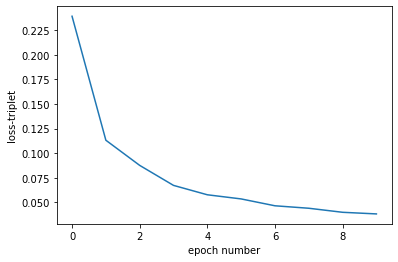

In [ ]:

plt.xlabel('epoch number')
plt.ylabel('loss-triplet')

plt.plot(np.arange(num_epochs),train_losses)

In [ ]:

with torch.no_grad():

    modelentropy.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(len(test_data)):
      sample=test_data[i]

      output1=modelentropy.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=modelentropy.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.98
Current Count is: 400
Accuracy on n way: 0.98
Current Count is: 600
Accuracy on n way: 0.98
Current Count is: 800
Accuracy on n way: 0.97625
Current Count is: 1000
Accuracy on n way: 0.979
Current Count is: 1200
Accuracy on n way: 0.9783333333333334
Current Count is: 1400
Accuracy on n way: 0.9764285714285714
Current Count is: 1600
Accuracy on n way: 0.97625
Current Count is: 1800
Accuracy on n way: 0.9761111111111112
Current Count is: 2000
Accuracy on n way: 0.9775
Current Count is: 2200
Accuracy on n way: 0.9781818181818182
Current Count is: 2400
Accuracy on n way: 0.9783333333333334
Current Count is: 2600
Accuracy on n way: 0.9788461538461538
Current Count is: 2800
Accuracy on n way: 0.9792857142857143
Current Count is: 3000
Accuracy on n way: 0.9796666666666667
Current Count is: 3200
Accuracy on n way: 0.9803125
Current Count is: 3400
Accuracy on n way: 0.9811764705882353
Current Count is: 3600
Accuracy on n way: 0.9811111111111112
Curr

In [ ]:
print('Final Test Accuracy if {:.4f} %'.format(correct*100/count))
adam_accuracy= (correct*100/count)

Final Test Accuracy if 98.1952 %


# Experiments on optimizers
    since the cross entropy is giving high test accuracy we will use the same model with different optimisers

## Using Adam Optimizer

In [ ]:
torch.manual_seed(101) 
modelentropy=SiameseNetwork()
modelentropy


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
count_parameters(modelentropy)

   144
    16
    16
    16
  2048
    32
    32
    32
 32768
   256
   256
   256
262144
   256
 32768
   128
   128
     1
______
331297


In [ ]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.0005
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(modelentropy.parameters(),lr=0.001,weight_decay=0.0005)

In [ ]:
train_dataset=SiameseNetworkDataset(train_data)
test_dataset=SiameseNetworkDataset(test_data)

In [ ]:

torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# training and validation loss were calculated after every epoch
import time
start_time = time.time()
num_epochs=10
device='cpu'
train_losses = []
val_losses = []
cur_step = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    modelentropy.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2,labels in train_loader:    # , label1,label2
        #labels = labels.to(device)
        output1,output2 = modelentropy(img1, img2)
        out = modelentropy.evaluate2(output1,output2)
        #print(out)
        #print(labels)
       # labels=labels.type(torch.LongTensor)
        loss = criterion(out,labels)
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    #break

    print('Epoch [{}/{}],Train Loss: {:.4f}'
        .format(epoch+1, num_epochs, avg_train_loss))
print("Finished Training")  
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

Starting epoch 1
Epoch [1/10],Train Loss: 0.2391
Starting epoch 2
Epoch [2/10],Train Loss: 0.1132
Starting epoch 3
Epoch [3/10],Train Loss: 0.0877
Starting epoch 4
Epoch [4/10],Train Loss: 0.0674
Starting epoch 5
Epoch [5/10],Train Loss: 0.0578
Starting epoch 6
Epoch [6/10],Train Loss: 0.0536
Starting epoch 7
Epoch [7/10],Train Loss: 0.0466
Starting epoch 8
Epoch [8/10],Train Loss: 0.0441
Starting epoch 9
Epoch [9/10],Train Loss: 0.0400
Starting epoch 10
Epoch [10/10],Train Loss: 0.0384
Finished Training

Duration: 1139 seconds


In [ ]:
train_losses

[0.23911849114359643,
 0.11320840045809746,
 0.0876744816573907,
 0.06735186016339124,
 0.057818484997224744,
 0.053604386077851666,
 0.04663610549795688,
 0.04413015615023977,
 0.04002872831378208,
 0.03837829730093327]

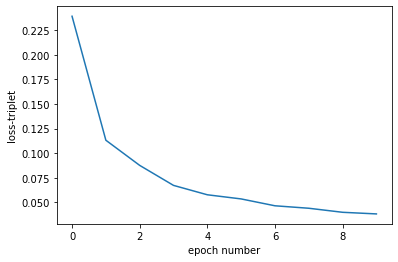

In [ ]:

plt.xlabel('epoch number')
plt.ylabel('loss-triplet')

plt.plot(np.arange(num_epochs),train_losses)

In [ ]:

with torch.no_grad():

    modelentropy.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(len(test_data)):
      sample=test_data[i]

      output1=modelentropy.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=modelentropy.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.98
Current Count is: 400
Accuracy on n way: 0.98
Current Count is: 600
Accuracy on n way: 0.98
Current Count is: 800
Accuracy on n way: 0.97625
Current Count is: 1000
Accuracy on n way: 0.979
Current Count is: 1200
Accuracy on n way: 0.9783333333333334
Current Count is: 1400
Accuracy on n way: 0.9764285714285714
Current Count is: 1600
Accuracy on n way: 0.97625
Current Count is: 1800
Accuracy on n way: 0.9761111111111112
Current Count is: 2000
Accuracy on n way: 0.9775
Current Count is: 2200
Accuracy on n way: 0.9781818181818182
Current Count is: 2400
Accuracy on n way: 0.9783333333333334
Current Count is: 2600
Accuracy on n way: 0.9788461538461538
Current Count is: 2800
Accuracy on n way: 0.9792857142857143
Current Count is: 3000
Accuracy on n way: 0.9796666666666667
Current Count is: 3200
Accuracy on n way: 0.9803125
Current Count is: 3400
Accuracy on n way: 0.9811764705882353
Current Count is: 3600
Accuracy on n way: 0.9811111111111112
Curr

In [ ]:
print('Final Test Accuracy if {:.4f} %'.format(correct*100/count))
adam_accuracy= (correct*100/count)

Final Test Accuracy if 98.1952 %


In [ ]:
#optimizer = torch.optim.RMSprop(modelRMS.parameters(), lr=0.001)

## Batch gradient descent  optimizer   = SGD(model.parameters(), lr=0.1)   with batch size ==1 in data loader

## Adam alrady calculated above

Optimizer_accuracies_test=[]
Optimizer_accuracies_test.append(adam_accuracy)




## Using RMSProp

In [ ]:
torch.manual_seed(101) 
modelRMSProp=SiameseNetwork()
modelRMSProp


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
count_parameters(modelRMSProp)

   144
    16
    16
    16
  2048
    32
    32
    32
 32768
   256
   256
   256
262144
   256
 32768
   128
   128
     1
______
331297


In [ ]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.0005
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.RMSprop(modelRMSProp.parameters(),lr=0.001,weight_decay=0.0005)

In [ ]:
train_dataset=SiameseNetworkDataset(train_data)
test_dataset=SiameseNetworkDataset(test_data)

In [ ]:

torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# training and validation loss were calculated after every epoch
import time
start_time = time.time()
num_epochs=13
device='cpu'
train_losses = []
val_losses = []
cur_step = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    modelRMSProp.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2,labels in train_loader:    # , label1,label2
        #labels = labels.to(device)
        output1,output2 = modelRMSProp(img1, img2)
        out = modelRMSProp.evaluate2(output1,output2)
        #print(out)
        #print(labels)
       # labels=labels.type(torch.LongTensor)
        loss = criterion(out,labels)
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    #break

    print('Epoch [{}/{}],Train Loss: {:.4f}'
        .format(epoch+1, num_epochs, avg_train_loss))
print("Finished Training")  
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

Starting epoch 1
Epoch [1/13],Train Loss: 0.2635
Starting epoch 2
Epoch [2/13],Train Loss: 0.1210
Starting epoch 3
Epoch [3/13],Train Loss: 0.0907
Starting epoch 4
Epoch [4/13],Train Loss: 0.0750
Starting epoch 5
Epoch [5/13],Train Loss: 0.0632
Starting epoch 6
Epoch [6/13],Train Loss: 0.0548
Starting epoch 7
Epoch [7/13],Train Loss: 0.0467
Starting epoch 8
Epoch [8/13],Train Loss: 0.0435
Starting epoch 9
Epoch [9/13],Train Loss: 0.0409
Starting epoch 10
Epoch [10/13],Train Loss: 0.0387
Starting epoch 11
Epoch [11/13],Train Loss: 0.0368
Starting epoch 12
Epoch [12/13],Train Loss: 0.0344
Starting epoch 13
Epoch [13/13],Train Loss: 0.0317
Finished Training

Duration: 2803 seconds


In [ ]:
train_losses

[0.263466134865065,
 0.1209808300230272,
 0.0907416033349475,
 0.07504424168063062,
 0.0632376454770565,
 0.054849307646746844,
 0.046726826987970545,
 0.043546151897242785,
 0.04090891107251601,
 0.03871957981027663,
 0.0368327965712821,
 0.034375107368188246,
 0.031701790805601954]

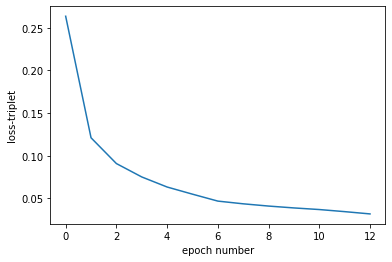

In [ ]:

plt.xlabel('epoch number')
plt.ylabel('loss-triplet')

plt.plot(np.arange(num_epochs),train_losses)

In [ ]:

with torch.no_grad():

    modelRMSProp.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(5000):
      sample=test_data[i]

      output1=modelRMSProp.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=modelRMSProp.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.99
Current Count is: 400
Accuracy on n way: 0.985
Current Count is: 600
Accuracy on n way: 0.9816666666666667
Current Count is: 800
Accuracy on n way: 0.97625
Current Count is: 1000
Accuracy on n way: 0.978
Current Count is: 1200
Accuracy on n way: 0.9808333333333333
Current Count is: 1400
Accuracy on n way: 0.9785714285714285
Current Count is: 1600
Accuracy on n way: 0.97875
Current Count is: 1800
Accuracy on n way: 0.9788888888888889
Current Count is: 2000
Accuracy on n way: 0.9805
Current Count is: 2200
Accuracy on n way: 0.9795454545454545
Current Count is: 2400
Accuracy on n way: 0.9791666666666666
Current Count is: 2600
Accuracy on n way: 0.9776923076923076
Current Count is: 2800
Accuracy on n way: 0.9782142857142857
Current Count is: 3000
Accuracy on n way: 0.9786666666666667
Current Count is: 3200
Accuracy on n way: 0.98
Current Count is: 3400
Accuracy on n way: 0.9811764705882353
Current Count is: 3600
Accuracy on n way: 0.98111111111

In [ ]:
print('Final Test Accuracy if {:.4f} %'.format(correct*100/count))
rms_accuracy= (correct*100/count)

Final Test Accuracy if 98.1600 %


In [ ]:
Optimizer_accuracies_test.append(rms_accuracy)
Optimizer_accuracies_test

[98.1952380952381, 98.16]

## Batch Gradient Descent
    For this we can use SGD optimiser with batch size == 1 then it will become batch gradient descent 

In [ ]:
torch.manual_seed(101) 
modelbatch=SiameseNetwork()
modelbatch


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
count_parameters(modelbatch)

   144
    16
    16
    16
  2048
    32
    32
    32
 32768
   256
   256
   256
262144
   256
 32768
   128
   128
     1
______
331297


In [ ]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.0005
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(modelbatch.parameters(),lr=0.001,weight_decay=0.0005)

In [ ]:
train_dataset=SiameseNetworkDataset(train_data)
test_dataset=SiameseNetworkDataset(test_data)

In [ ]:

torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)       ############Batch size should be 1 for Batch gradient descent 

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# training and validation loss were calculated after every epoch
import time
start_time = time.time()
num_epochs=10
device='cpu'
train_losses = []
val_losses = []
cur_step = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    modelbatch.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2,labels in train_loader:    # , label1,label2
        #labels = labels.to(device)
        output1,output2 = modelbatch(img1, img2)
        out = modelbatch.evaluate2(output1,output2)
        #print(out)
        #print(labels)
       # labels=labels.type(torch.LongTensor)
        loss = criterion(out,labels)
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    #break

    print('Epoch [{}/{}],Train Loss: {:.4f}'
        .format(epoch+1, num_epochs, avg_train_loss))
print("Finished Training")  
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

Starting epoch 1
Epoch [1/10],Train Loss: 0.2747
Starting epoch 2
Epoch [2/10],Train Loss: 0.1038
Starting epoch 3
Epoch [3/10],Train Loss: 0.0742
Starting epoch 4
Epoch [4/10],Train Loss: 0.0562
Starting epoch 5
Epoch [5/10],Train Loss: 0.0480
Starting epoch 6
Epoch [6/10],Train Loss: 0.0396
Starting epoch 7
Epoch [7/10],Train Loss: 0.0369
Starting epoch 8
Epoch [8/10],Train Loss: 0.0312
Starting epoch 9
Epoch [9/10],Train Loss: 0.0275
Starting epoch 10
Epoch [10/10],Train Loss: 0.0262
Finished Training

Duration: 5343 seconds


In [ ]:
train_losses

[0.2746602237586379,
 0.10382671357066692,
 0.07422494424644337,
 0.05624056531613401,
 0.047959513592248974,
 0.03959886035450937,
 0.03685488770408048,
 0.031223034590520286,
 0.027485992106378563,
 0.026192057822867036]

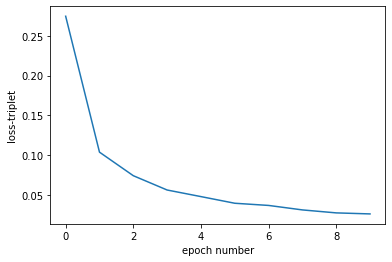

In [ ]:

plt.xlabel('epoch number')
plt.ylabel('loss-triplet')

plt.plot(np.arange(num_epochs),train_losses)

In [ ]:

with torch.no_grad():

    modelbatch.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(10000):
      sample=test_data[i]

      output1=modelbatch.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=modelbatch.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.915
Current Count is: 400
Accuracy on n way: 0.9275
Current Count is: 600
Accuracy on n way: 0.93
Current Count is: 800
Accuracy on n way: 0.93
Current Count is: 1000
Accuracy on n way: 0.938
Current Count is: 1200
Accuracy on n way: 0.94
Current Count is: 1400
Accuracy on n way: 0.9421428571428572
Current Count is: 1600
Accuracy on n way: 0.94375
Current Count is: 1800
Accuracy on n way: 0.9427777777777778
Current Count is: 2000
Accuracy on n way: 0.9465
Current Count is: 2200
Accuracy on n way: 0.945
Current Count is: 2400
Accuracy on n way: 0.9433333333333334
Current Count is: 2600
Accuracy on n way: 0.9415384615384615
Current Count is: 2800
Accuracy on n way: 0.9407142857142857
Current Count is: 3000
Accuracy on n way: 0.942
Current Count is: 3200
Accuracy on n way: 0.941875
Current Count is: 3400
Accuracy on n way: 0.9441176470588235
Current Count is: 3600
Accuracy on n way: 0.9444444444444444
Current Count is: 3800
Accuracy on n way: 0.9

In [ ]:
print('Final Test Accuracy if {:.4f} %'.format(correct*100/count))
batch_accuracy= (correct*100/count)

Final Test Accuracy if 94.6400 %


In [ ]:
Optimizer_accuracies_test.append(batch_accuracy)
Optimizer_accuracies_test

[98.1952380952381, 98.16, 94.64]

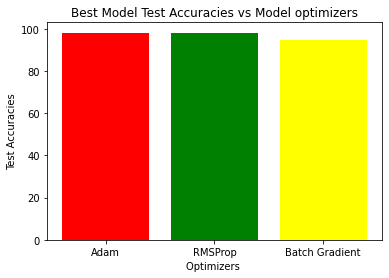

In [ ]:
# plotting a bar chart
left=[1,2,3]
height=Optimizer_accuracies_test
tick_label=['Adam','RMSProp','Batch Gradient']
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green','yellow'])
  
# naming the x-axis
plt.xlabel('Optimizers ')
# naming the y-axis
plt.ylabel('Test Accuracies')
# plot title
plt.title('Best Model Test Accuracies vs Model optimizers')
  
# function to show the plot
plt.show()

## Hyper parameter tuning 
    Varying the learning rate between 0.0001 to 0.1  and weight decay on Adam optimizer with with Cross entropy loss

In [ ]:
import itertools

learning_rate=[0.0001,0.001,0.01,0.1]
learning_rate=learning_rate[::-1]

weight_decays=[0.0005,0.005,0.05,0.01]

#permute=list(map(','.join, itertools.chain(itertools.product(learning_rate, weight_decays), itertools.product(learning_rate, weight_decays))))

#print(permute)

### Using learning rate 0.1

In [ ]:
torch.manual_seed(101) 
model0=SiameseNetwork()
model0


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
count_parameters(model0)

   144
    16
    16
    16
  2048
    32
    32
    32
 32768
   256
   256
   256
262144
   256
 32768
   128
   128
     1
______
331297


In [ ]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.0005
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model0.parameters(),lr=0.1)

In [ ]:
train_dataset=SiameseNetworkDataset(train_data)
test_dataset=SiameseNetworkDataset(test_data)

In [ ]:

torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:

  

def train_hyper(model,optimizer,criterion,learn_rate,train_loader):
 

  print('#'*20+'Learning rate = {} '.format(learn_rate)+'#'*20+'')

  import time
  start_time = time.time()
  num_epochs=10 
  device='cpu'
  train_losses = []
  cur_step = 0
  for epoch in range(num_epochs):
      running_loss = 0.0
      model.train()
      print("Starting epoch " + str(epoch+1))
      for img1, img2,labels in train_loader:    # , label1,label2
          #labels = labels.to(device)
          output1,output2 = model(img1, img2)
          out = model.evaluate2(output1,output2)
          #print(out)
          #print(labels)
        # labels=labels.type(torch.LongTensor)
          loss = criterion(out,labels)
        
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      avg_train_loss = running_loss / len(train_loader)
      train_losses.append(avg_train_loss)
      #break

      print('Epoch [{}/{}],Train Loss: {:.4f}'
          .format(epoch+1, num_epochs, avg_train_loss))
  print("Finished Training")  
  
  print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

  return train_losses

In [ ]:
train_losses=train_hyper(model0,optimizer,criterion,0.1,train_loader)

####################Learning rate = 0.1 ####################
Starting epoch 1
Epoch [1/5],Train Loss: 2.1103
Starting epoch 2
Epoch [2/5],Train Loss: 0.3471
Starting epoch 3
Epoch [3/5],Train Loss: 0.2936
Starting epoch 4
Epoch [4/5],Train Loss: 0.2465
Starting epoch 5
Epoch [5/5],Train Loss: 0.2293
Finished Training

Duration: 505 seconds


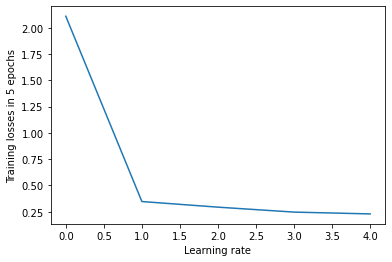

In [ ]:

plt.xlabel('Learning rate')
plt.ylabel('Training losses in 5 epochs')

plt.plot(np.arange(5),train_losses)

In [ ]:

with torch.no_grad():

    modelentropy.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(1000):
      sample=test_data[i]

      output1=modelentropy.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=modelentropy.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.115
Current Count is: 400
Accuracy on n way: 0.11
Current Count is: 600
Accuracy on n way: 0.105
Current Count is: 800
Accuracy on n way: 0.09875
Current Count is: 1000
Accuracy on n way: 0.104
Final Test Accuracy if 10.4000


In [ ]:
print('Final Test Accuracy if {:.4f} %'.format(correct*100/count))
model_0_accuracy= (correct*100/count)

Final Test Accuracy if 10.4000 %


In [ ]:
hyper_learn_accu=[]
hyper_learn_accu.append(model_0_accuracy)

In [ ]:
hyper_learn_accu

[10.4]

### Learning rate == 0.01

In [ ]:
torch.manual_seed(101) 
model1=SiameseNetwork()
model1


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.0005
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model1.parameters(),lr=0.01)

In [ ]:
train_losses=train_hyper(model1,optimizer,criterion,0.01,train_loader)

####################Learning rate = 0.01 ####################
Starting epoch 1
Epoch [1/10],Train Loss: 0.2950
Starting epoch 2
Epoch [2/10],Train Loss: 0.1153
Starting epoch 3
Epoch [3/10],Train Loss: 0.0752
Starting epoch 4
Epoch [4/10],Train Loss: 0.0602
Starting epoch 5
Epoch [5/10],Train Loss: 0.0522
Starting epoch 6
Epoch [6/10],Train Loss: 0.0497
Starting epoch 7
Epoch [7/10],Train Loss: 0.0460
Starting epoch 8
Epoch [8/10],Train Loss: 0.0458
Starting epoch 9
Epoch [9/10],Train Loss: 0.0426
Starting epoch 10
Epoch [10/10],Train Loss: 0.0329
Finished Training

Duration: 1015 seconds


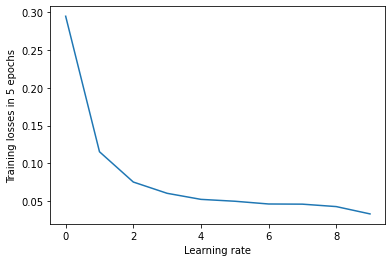

In [ ]:

plt.xlabel('Learning rate')
plt.ylabel('Training losses in 5 epochs')

plt.plot(np.arange(10),train_losses)

In [ ]:

def tes_hyper(model,test_data):
  with torch.no_grad():

      model.eval()
      correct = 0
      count = 0
      m = nn.Sigmoid()

      for i in range(1000):
        sample=test_data[i]

        output1=model.evaluate(sample[0].unsqueeze(0))
        #similarity=[]    
        dis_simi=999
        pred=-1
        for key,values in k_way_dict.items():
          
          
          for value in values:
            out2=model.evaluate(value.unsqueeze(0))
            #infer=modelTriplet.evaluate2(output1,out2)
            infer= inference(output1,out2)
            
            #infer=m(infer)
            #print(infer)
            #print('##################')
            if dis_simi > infer[0].item():
                dis_simi=infer[0].item()
                pred=int(key)
        #print(sample[1])
        #print(pred)
        if sample[1]==pred:
          correct+=1

        count += 1
        if count % 200 == 0:
            print("Current Count is: {}".format(count))
            print('Accuracy on n way: {}'.format(correct/count))

        
      print('Final Test Accuracy if {:.4f}'.format(correct*100/count))

      acc=correct*100/count

      return acc



In [ ]:
accuracy=tes_hyper(model1,test_data)

Current Count is: 200
Accuracy on n way: 0.745
Current Count is: 400
Accuracy on n way: 0.735
Current Count is: 600
Accuracy on n way: 0.7383333333333333
Current Count is: 800
Accuracy on n way: 0.75625
Current Count is: 1000
Accuracy on n way: 0.762
Final Test Accuracy if 76.2000


In [ ]:
print('Final Test Accuracy if {:.4f} %'.format(accuracy))
model_1_accuracy= (accuracy)

Final Test Accuracy if 76.2000 %


In [ ]:
hyper_learn_accu.append(model_1_accuracy)
hyper_learn_accu

[10.4, 76.2]

### using learning rat=0.001

In [ ]:
torch.manual_seed(101) 
modelentropy=SiameseNetwork()
modelentropy


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.0005
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(modelentropy.parameters(),lr=0.001)

In [25]:
train_dataset=SiameseNetworkDataset(train_data)
test_dataset=SiameseNetworkDataset(test_data)

In [26]:

torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# training and validation loss were calculated after every epoch
import time
start_time = time.time()
num_epochs=10
device='cpu'
train_losses = []
val_losses = []
cur_step = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    modelentropy.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2,labels in train_loader:    # , label1,label2
        #labels = labels.to(device)
        output1,output2 = modelentropy(img1, img2)
        out = modelentropy.evaluate2(output1,output2)
        #print(out)
        #print(labels)
       # labels=labels.type(torch.LongTensor)
        loss = criterion(out,labels)
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    #break

    print('Epoch [{}/{}],Train Loss: {:.4f}'
        .format(epoch+1, num_epochs, avg_train_loss))
print("Finished Training")  
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

Starting epoch 1
Epoch [1/10],Train Loss: 0.2391
Starting epoch 2
Epoch [2/10],Train Loss: 0.1132
Starting epoch 3
Epoch [3/10],Train Loss: 0.0877
Starting epoch 4
Epoch [4/10],Train Loss: 0.0674
Starting epoch 5
Epoch [5/10],Train Loss: 0.0578
Starting epoch 6
Epoch [6/10],Train Loss: 0.0536
Starting epoch 7
Epoch [7/10],Train Loss: 0.0466
Starting epoch 8
Epoch [8/10],Train Loss: 0.0441
Starting epoch 9
Epoch [9/10],Train Loss: 0.0400
Starting epoch 10
Epoch [10/10],Train Loss: 0.0384
Finished Training

Duration: 1139 seconds


In [ ]:
train_losses

[0.23911849114359643,
 0.11320840045809746,
 0.0876744816573907,
 0.06735186016339124,
 0.057818484997224744,
 0.053604386077851666,
 0.04663610549795688,
 0.04413015615023977,
 0.04002872831378208,
 0.03837829730093327]

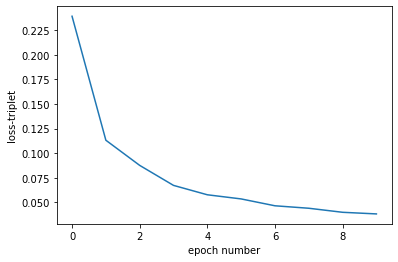

In [ ]:

plt.xlabel('epoch number')
plt.ylabel('loss-triplet')

plt.plot(np.arange(num_epochs),train_losses)

In [ ]:

with torch.no_grad():

    modelentropy.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(len(test_data)):
      sample=test_data[i]

      output1=modelentropy.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=modelentropy.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.98
Current Count is: 400
Accuracy on n way: 0.98
Current Count is: 600
Accuracy on n way: 0.98
Current Count is: 800
Accuracy on n way: 0.97625
Current Count is: 1000
Accuracy on n way: 0.979
Current Count is: 1200
Accuracy on n way: 0.9783333333333334
Current Count is: 1400
Accuracy on n way: 0.9764285714285714
Current Count is: 1600
Accuracy on n way: 0.97625
Current Count is: 1800
Accuracy on n way: 0.9761111111111112
Current Count is: 2000
Accuracy on n way: 0.9775
Current Count is: 2200
Accuracy on n way: 0.9781818181818182
Current Count is: 2400
Accuracy on n way: 0.9783333333333334
Current Count is: 2600
Accuracy on n way: 0.9788461538461538
Current Count is: 2800
Accuracy on n way: 0.9792857142857143
Current Count is: 3000
Accuracy on n way: 0.9796666666666667
Current Count is: 3200
Accuracy on n way: 0.9803125
Current Count is: 3400
Accuracy on n way: 0.9811764705882353
Current Count is: 3600
Accuracy on n way: 0.9811111111111112
Curr

In [ ]:
print('Final Test Accuracy if {:.4f} %'.format(correct*100/count))
adam_accuracy= (correct*100/count)

Final Test Accuracy if 98.1952 %


In [ ]:
hyper_learn_accu

[10.4, 76.2, 98.1952380952381]

### Using learning rate 0.0001

In [27]:
torch.manual_seed(101) 
model3=SiameseNetwork()
model3


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [28]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.0005
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model3.parameters(),lr=0.0001)

In [29]:
# training and validation loss were calculated after every epoch
import time
start_time = time.time()
num_epochs=10
device='cpu'
train_losses = []
val_losses = []
cur_step = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    model3.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2,labels in train_loader:    # , label1,label2
        #labels = labels.to(device)
        output1,output2 = model3(img1, img2)
        out = model3.evaluate2(output1,output2)
        #print(out)
        #print(labels)
       # labels=labels.type(torch.LongTensor)
        loss = criterion(out,labels)
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    #break

    print('Epoch [{}/{}],Train Loss: {:.4f}'
        .format(epoch+1, num_epochs, avg_train_loss))
print("Finished Training")  
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

Starting epoch 1
Epoch [1/10],Train Loss: 0.4340
Starting epoch 2
Epoch [2/10],Train Loss: 0.2201
Starting epoch 3
Epoch [3/10],Train Loss: 0.1578
Starting epoch 4
Epoch [4/10],Train Loss: 0.1248
Starting epoch 5
Epoch [5/10],Train Loss: 0.1057
Starting epoch 6
Epoch [6/10],Train Loss: 0.0875
Starting epoch 7
Epoch [7/10],Train Loss: 0.0789
Starting epoch 8
Epoch [8/10],Train Loss: 0.0688
Starting epoch 9
Epoch [9/10],Train Loss: 0.0623
Starting epoch 10
Epoch [10/10],Train Loss: 0.0577
Finished Training

Duration: 1145 seconds


In [30]:
train_losses

[0.4339933981396714,
 0.2200767826212912,
 0.15780314305911258,
 0.1248164007098091,
 0.10568756645887482,
 0.08753444726521871,
 0.07889402967554573,
 0.06875620076470837,
 0.06225014762116634,
 0.05767547698615461]

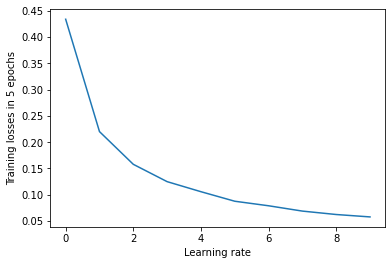

In [31]:

plt.xlabel('Learning rate')
plt.ylabel('Training losses in 5 epochs')

plt.plot(np.arange(10),train_losses)

In [37]:

with torch.no_grad():

    model3.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(5000):
      sample=test_data[i]

      output1=model3.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=model3.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.975
Current Count is: 400
Accuracy on n way: 0.9725
Current Count is: 600
Accuracy on n way: 0.9683333333333334
Current Count is: 800
Accuracy on n way: 0.9675
Current Count is: 1000
Accuracy on n way: 0.971
Current Count is: 1200
Accuracy on n way: 0.9691666666666666
Current Count is: 1400
Accuracy on n way: 0.9692857142857143
Current Count is: 1600
Accuracy on n way: 0.970625
Current Count is: 1800
Accuracy on n way: 0.9694444444444444
Current Count is: 2000
Accuracy on n way: 0.9695
Current Count is: 2200
Accuracy on n way: 0.9686363636363636
Current Count is: 2400
Accuracy on n way: 0.9691666666666666
Current Count is: 2600
Accuracy on n way: 0.9688461538461538
Current Count is: 2800
Accuracy on n way: 0.9692857142857143
Current Count is: 3000
Accuracy on n way: 0.9713333333333334
Current Count is: 3200
Accuracy on n way: 0.97125
Current Count is: 3400
Accuracy on n way: 0.971764705882353
Current Count is: 3600
Accuracy on n way: 0.9713888

In [38]:
print('Final Test Accuracy if {:.4f} %'.format(correct*100/count))
accuracy= (correct*100/count)

Final Test Accuracy if 97.2600 %


In [39]:
print('Final Test Accuracy if {:.4f} %'.format(accuracy))
model_3_accuracy= (accuracy)

Final Test Accuracy if 97.2600 %


In [40]:
hyper_learn_accu=[10.4,76.2,98.19,97.26]


In [41]:
hyper_learn_accu

[10.4, 76.2, 98.19, 97.26]

### Graphs comparing learning rates on Best Model

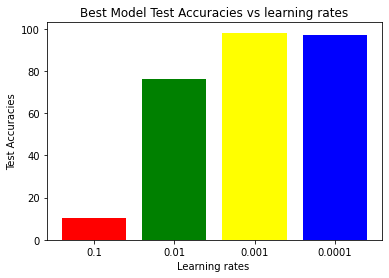

In [42]:
# plotting a bar chart
left=[1,2,3,4]
height=hyper_learn_accu
tick_label=['0.1','0.01','0.001','0.0001']
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green','yellow','blue'])
  
# naming the x-axis
plt.xlabel('Learning rates ')
# naming the y-axis
plt.ylabel('Test Accuracies')
# plot title
plt.title('Best Model Test Accuracies vs learning rates')
  
# function to show the plot
plt.show()

## Hyper parameter tuning weight_decay:
     using weight decay or regularisation factor lambda on the best Model i.e
     learning rate 0.001 and with cross entropy loss.

     we'll vary weight decay as follows 0.01, 0.001,0.0005





###  Weight_decay=0.01

In [43]:
torch.manual_seed(101) 
modelentropy=SiameseNetwork()
modelentropy


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [44]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.01
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(modelentropy.parameters(),lr=0.001,weight_decay=0.01)

In [45]:
train_dataset=SiameseNetworkDataset(train_data)
test_dataset=SiameseNetworkDataset(test_data)

In [46]:

torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [47]:
# training and validation loss were calculated after every epoch
import time
start_time = time.time()
num_epochs=10
device='cpu'
train_losses = []
val_losses = []
cur_step = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    modelentropy.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2,labels in train_loader:    # , label1,label2
        #labels = labels.to(device)
        output1,output2 = modelentropy(img1, img2)
        out = modelentropy.evaluate2(output1,output2)
        #print(out)
        #print(labels)
       # labels=labels.type(torch.LongTensor)
        loss = criterion(out,labels)
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    #break

    print('Epoch [{}/{}],Train Loss: {:.4f}'
        .format(epoch+1, num_epochs, avg_train_loss))
print("Finished Training")  
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

Starting epoch 1
Epoch [1/10],Train Loss: 0.3059
Starting epoch 2
Epoch [2/10],Train Loss: 0.1992
Starting epoch 3
Epoch [3/10],Train Loss: 0.1757
Starting epoch 4
Epoch [4/10],Train Loss: 0.1638
Starting epoch 5
Epoch [5/10],Train Loss: 0.1515
Starting epoch 6
Epoch [6/10],Train Loss: 0.1404
Starting epoch 7
Epoch [7/10],Train Loss: 0.1304
Starting epoch 8
Epoch [8/10],Train Loss: 0.1257
Starting epoch 9
Epoch [9/10],Train Loss: 0.1229
Starting epoch 10
Epoch [10/10],Train Loss: 0.1201
Finished Training

Duration: 1156 seconds


In [50]:
train_losses

[0.305909622475809,
 0.19920533317692427,
 0.17566406229624942,
 0.1637521330951428,
 0.15149823404392418,
 0.14037997391150922,
 0.13036238196857122,
 0.12574828571202804,
 0.12291676222669835,
 0.1200959926205022]

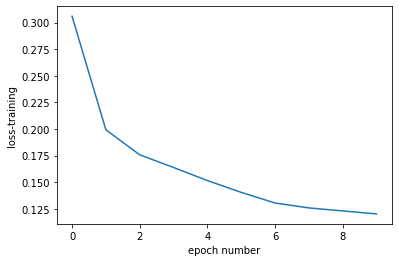

In [51]:

plt.xlabel('epoch number')
plt.ylabel('loss-training')

plt.plot(np.arange(num_epochs),train_losses)

In [53]:

with torch.no_grad():

    modelentropy.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(5000):
      sample=test_data[i]

      output1=modelentropy.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=modelentropy.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.97
Current Count is: 400
Accuracy on n way: 0.975
Current Count is: 600
Accuracy on n way: 0.9783333333333334
Current Count is: 800
Accuracy on n way: 0.97625
Current Count is: 1000
Accuracy on n way: 0.978
Current Count is: 1200
Accuracy on n way: 0.9716666666666667
Current Count is: 1400
Accuracy on n way: 0.9721428571428572
Current Count is: 1600
Accuracy on n way: 0.975625
Current Count is: 1800
Accuracy on n way: 0.975
Current Count is: 2000
Accuracy on n way: 0.974
Current Count is: 2200
Accuracy on n way: 0.9731818181818181
Current Count is: 2400
Accuracy on n way: 0.9729166666666667
Current Count is: 2600
Accuracy on n way: 0.9734615384615385
Current Count is: 2800
Accuracy on n way: 0.9732142857142857
Current Count is: 3000
Accuracy on n way: 0.9746666666666667
Current Count is: 3200
Accuracy on n way: 0.975625
Current Count is: 3400
Accuracy on n way: 0.9758823529411764
Current Count is: 3600
Accuracy on n way: 0.975
Current Count is

In [54]:
print('Final Test Accuracy if {:.4f} %'.format(correct*100/count))
accuracy= (correct*100/count)

Final Test Accuracy if 97.5400 %


###  Weight_decay=0.001

In [55]:
torch.manual_seed(101) 
modelentropy=SiameseNetwork()
modelentropy


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [56]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(modelentropy.parameters(),lr=0.001,weight_decay=0.001)

In [57]:
train_dataset=SiameseNetworkDataset(train_data)
test_dataset=SiameseNetworkDataset(test_data)

In [58]:

torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [59]:
# training and validation loss were calculated after every epoch
import time
start_time = time.time()
num_epochs=10
device='cpu'
train_losses = []
val_losses = []
cur_step = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    modelentropy.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2,labels in train_loader:    # , label1,label2
        #labels = labels.to(device)
        output1,output2 = modelentropy(img1, img2)
        out = modelentropy.evaluate2(output1,output2)
        #print(out)
        #print(labels)
       # labels=labels.type(torch.LongTensor)
        loss = criterion(out,labels)
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    #break

    print('Epoch [{}/{}],Train Loss: {:.4f}'
        .format(epoch+1, num_epochs, avg_train_loss))
print("Finished Training")  
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

Starting epoch 1
Epoch [1/10],Train Loss: 0.2382
Starting epoch 2
Epoch [2/10],Train Loss: 0.1236
Starting epoch 3
Epoch [3/10],Train Loss: 0.0905
Starting epoch 4
Epoch [4/10],Train Loss: 0.0777
Starting epoch 5
Epoch [5/10],Train Loss: 0.0664
Starting epoch 6
Epoch [6/10],Train Loss: 0.0605
Starting epoch 7
Epoch [7/10],Train Loss: 0.0532
Starting epoch 8
Epoch [8/10],Train Loss: 0.0506
Starting epoch 9
Epoch [9/10],Train Loss: 0.0496
Starting epoch 10
Epoch [10/10],Train Loss: 0.0462
Finished Training

Duration: 1267 seconds


In [60]:
train_losses

[0.23823911990894348,
 0.12357950334494211,
 0.0905477066923465,
 0.07766781588446121,
 0.06643570044971242,
 0.060458200907676805,
 0.05318036083968318,
 0.050605204498053204,
 0.049627259540922786,
 0.046243856214367]

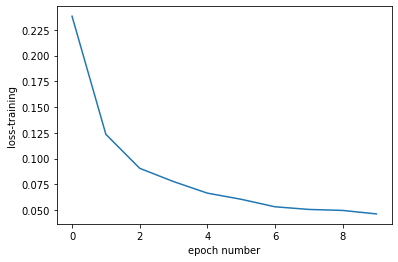

In [61]:

plt.xlabel('epoch number')
plt.ylabel('loss-training')

plt.plot(np.arange(num_epochs),train_losses)

In [62]:

with torch.no_grad():

    modelentropy.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(5000):
      sample=test_data[i]

      output1=modelentropy.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=modelentropy.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.99
Current Count is: 400
Accuracy on n way: 0.985
Current Count is: 600
Accuracy on n way: 0.985
Current Count is: 800
Accuracy on n way: 0.985
Current Count is: 1000
Accuracy on n way: 0.985
Current Count is: 1200
Accuracy on n way: 0.9816666666666667
Current Count is: 1400
Accuracy on n way: 0.9828571428571429
Current Count is: 1600
Accuracy on n way: 0.984375
Current Count is: 1800
Accuracy on n way: 0.9822222222222222
Current Count is: 2000
Accuracy on n way: 0.982
Current Count is: 2200
Accuracy on n way: 0.98
Current Count is: 2400
Accuracy on n way: 0.9795833333333334
Current Count is: 2600
Accuracy on n way: 0.98
Current Count is: 2800
Accuracy on n way: 0.98
Current Count is: 3000
Accuracy on n way: 0.981
Current Count is: 3200
Accuracy on n way: 0.98125
Current Count is: 3400
Accuracy on n way: 0.9811764705882353
Current Count is: 3600
Accuracy on n way: 0.9805555555555555
Current Count is: 3800
Accuracy on n way: 0.9810526315789474


In [63]:
print('Final Test Accuracy if {:.4f} %'.format(correct*100/count))
accuracy= (correct*100/count)

Final Test Accuracy if 98.2600 %


###  Weight_decay=0.0005

In [65]:
torch.manual_seed(101) 
modelentropy=SiameseNetwork()
modelentropy


SiameseNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fcout): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [66]:
#criterion=Regularised cross rntropy loss adding L2 regularisation factor of 0.0005
criterion = nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(modelentropy.parameters(),lr=0.001,weight_decay=0.0005)

In [67]:
train_dataset=SiameseNetworkDataset(train_data)
test_dataset=SiameseNetworkDataset(test_data)

In [68]:

torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [69]:
# training and validation loss were calculated after every epoch
import time
start_time = time.time()
num_epochs=10
device='cpu'
train_losses = []
val_losses = []
cur_step = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    modelentropy.train()
    print("Starting epoch " + str(epoch+1))
    for img1, img2,labels in train_loader:    # , label1,label2
        #labels = labels.to(device)
        output1,output2 = modelentropy(img1, img2)
        out = modelentropy.evaluate2(output1,output2)
        #print(out)
        #print(labels)
       # labels=labels.type(torch.LongTensor)
        loss = criterion(out,labels)
      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    #break

    print('Epoch [{}/{}],Train Loss: {:.4f}'
        .format(epoch+1, num_epochs, avg_train_loss))
print("Finished Training")  
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

Starting epoch 1
Epoch [1/10],Train Loss: 0.2424
Starting epoch 2
Epoch [2/10],Train Loss: 0.1172
Starting epoch 3
Epoch [3/10],Train Loss: 0.0874
Starting epoch 4
Epoch [4/10],Train Loss: 0.0720
Starting epoch 5
Epoch [5/10],Train Loss: 0.0583
Starting epoch 6
Epoch [6/10],Train Loss: 0.0536
Starting epoch 7
Epoch [7/10],Train Loss: 0.0484
Starting epoch 8
Epoch [8/10],Train Loss: 0.0468
Starting epoch 9
Epoch [9/10],Train Loss: 0.0431
Starting epoch 10
Epoch [10/10],Train Loss: 0.0405
Finished Training

Duration: 1327 seconds


In [70]:
train_losses

[0.24242331803757317,
 0.11717706714205596,
 0.08735849028263165,
 0.07197131377701857,
 0.058297194550003935,
 0.053564070087230325,
 0.048378001955546895,
 0.04679545912017324,
 0.04311372900799829,
 0.04049427752021928]

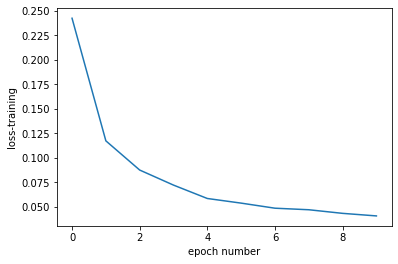

In [71]:

plt.xlabel('epoch number')
plt.ylabel('loss-training')

plt.plot(np.arange(num_epochs),train_losses)

In [72]:

with torch.no_grad():

    modelentropy.eval()
    correct = 0
    count = 0
    m = nn.Sigmoid()

    for i in range(5000):
      sample=test_data[i]

      output1=modelentropy.evaluate(sample[0].unsqueeze(0))
      #similarity=[]    
      dis_simi=999
      pred=-1
      for key,values in k_way_dict.items():
        
        
        for value in values:
          out2=modelentropy.evaluate(value.unsqueeze(0))
          #infer=modelTriplet.evaluate2(output1,out2)
          infer= inference(output1,out2)
          
          #infer=m(infer)
          #print(infer)
          #print('##################')
          if dis_simi > infer[0].item():
              dis_simi=infer[0].item()
              pred=int(key)
      #print(sample[1])
      #print(pred)
      if sample[1]==pred:
        correct+=1

      count += 1
      if count % 200 == 0:
          print("Current Count is: {}".format(count))
          print('Accuracy on n way: {}'.format(correct/count))

      
    print('Final Test Accuracy if {:.4f}'.format(correct*100/count))



Current Count is: 200
Accuracy on n way: 0.985
Current Count is: 400
Accuracy on n way: 0.9775
Current Count is: 600
Accuracy on n way: 0.975
Current Count is: 800
Accuracy on n way: 0.9775
Current Count is: 1000
Accuracy on n way: 0.978
Current Count is: 1200
Accuracy on n way: 0.975
Current Count is: 1400
Accuracy on n way: 0.975
Current Count is: 1600
Accuracy on n way: 0.97625
Current Count is: 1800
Accuracy on n way: 0.9755555555555555
Current Count is: 2000
Accuracy on n way: 0.9765
Current Count is: 2200
Accuracy on n way: 0.9745454545454545
Current Count is: 2400
Accuracy on n way: 0.97375
Current Count is: 2600
Accuracy on n way: 0.9738461538461538
Current Count is: 2800
Accuracy on n way: 0.9742857142857143
Current Count is: 3000
Accuracy on n way: 0.9753333333333334
Current Count is: 3200
Accuracy on n way: 0.97625
Current Count is: 3400
Accuracy on n way: 0.9770588235294118
Current Count is: 3600
Accuracy on n way: 0.9766666666666667
Current Count is: 3800
Accuracy on n way

In [73]:
print('Final Test Accuracy if {:.4f} %'.format(correct*100/count))
accuracy= (correct*100/count)

Final Test Accuracy if 98.0000 %


In [74]:
hyper_learn_accu=[97.54,98.26,98.00]

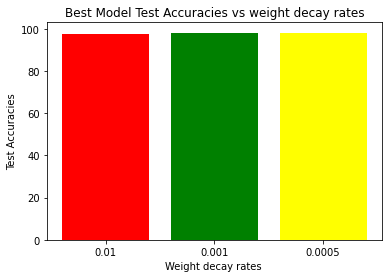

In [75]:
# plotting a bar chart
left=[1,2,3]
height=hyper_learn_accu
tick_label=['0.01','0.001','0.0005']
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green','yellow'])
  
# naming the x-axis
plt.xlabel('Weight decay rates ')
# naming the y-axis
plt.ylabel('Test Accuracies')
# plot title
plt.title('Best Model Test Accuracies vs weight decay rates')
  
# function to show the plot
plt.show()

## Pros and cons of siamese networks:
    Pros:
    1.It is useful to classify even when we have lesser number of images to 
    compare, as seen above when we have 10 class 10 images also we are able to produce accuracies of 98%.
    2.It is useful in feature extraction. We are effectively learning the embeddings 
    from the images which can be used later to calculate the pairwise distance 
    3.It can be used for wide range of applications like signature verification,
    face verification etc,.
    Cons:
    1.It takes lot of time for training. we need to extrapolate the data set 
    to train the model on sufficient pairs. So that it will be able to learn effectively.
    2.It does not calculates the probabilities. it just creates embeddings which 
    should be used for distance calculation.So, a additional step is required for classification
    3.If it is few shot learning predicting might take longer time.

## Additional functions/ code

In [ ]:
def eval(model, test_loader):
    with torch.no_grad():

        model.eval()
        correct = 0
        count = 0
        for mainImg, imgSets, label in test_loader:
            #mainImg = mainImg.to(device)
   
            predVal = 0
            pred = -1
            
            # determine which category an image belongs to
            for i, testImg in enumerate(imgSets):
                #testImg = testImg.to(device)

                output1,output2 = model(mainImg, testImg)
                
                output=model.evaluate(output1,output2)
                #out=torch.abs(output1 - output2)
                #print(output.size())
                #print(output)

                #print(torch.max(output))
                print(output[0].item())
                break

                if output[0].item() > predVal:
                    pred = i
                    #predVal=torch.max(output)
                    predVal = output[0].item()
                    #print(pred)
                    #print(predVal)
            break
            
            if pred == label:
                correct += 1
                #print(correct)
                
            count += 1
            if count % 20 == 0:
                print("Current Count is: {}".format(count))
                print('Accuracy on n way: {}'.format(correct/count))

        return correct*100/count

In [ ]:
test_dataset= EvalSet(test_data)
eval_loader=DataLoader(test_dataset, batch_size=, shuffle=False)

In [ ]:
test_accuracy =eval(model, eval_loader)